In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
import re
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
from keras.layers import Input, Flatten, Activation, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [2]:
height, width, depth = 96, 96, 3
save_path = 'python/first_model.model'

In [3]:
def load_dataset(path, height, width, least_num):
    image_list, label_list = [], []
    for root, dirs, files in os.walk(path):
        temp_images, temp_labels = [], []
        for file in files:
            try:
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                image = cv2.resize(image, (height, width))
                temp_images.append(image)
                temp_labels.append(root.split('\\')[1])
            except:
                continue
        if len(temp_images)>= least_num:
            image_list.extend(temp_images)
            label_list.extend(temp_labels)
            
    num_classes = len(np.unique(label_list))
    # num_classes = 1
    
    return image_list, label_list, num_classes

In [4]:
def get_model(height, weight, depth, num_classes):
    K.clear_session()
    
    X_input = Input((height, width, depth))
    
    X = Conv2D(32, (3,3), padding = 'same', activation = 'relu')(X_input)
    X = Conv2D(32, (3,3), padding = 'same', activation = 'relu')(X)
    X = Flatten()(X)
    X = Dense (num_classes, activation = 'softmax')(X)
    
    model = Model(inputs = X_input, outputs = X)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics =['accuracy'])
    
    return model

In [5]:
def train_model(model, epochs, save_path, train_X, train_y, test_X, test_y, data_augmentation = False):
    batch_size = 32
    early_stopping = EarlyStopping(patience=20, verbose=1)
    model_checkpoint = ModelCheckpoint(save_path, save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
    callbacks = [early_stopping, model_checkpoint, reduce_lr]
    
    if data_augmentation:
        datagen = ImageDataGenerator(
            rescale=1/255.,
            featurewise_center=False, # Set input mean to 0 over the dataset, feature-wise.
            samplewise_center=False, # Set each sample mean to 0.
            featurewise_std_normalization=False, # Divide inputs by std of the dataset, feature-wise.
            samplewise_std_normalization=False, # Divide each input by its std.
            zca_whitening=False, # Apply ZCA whitening.
            rotation_range=15, # Degree range for random rotations.
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False)

    else:
        datagen = ImageDataGenerator(
            rescale=1/255)
    
    history = model.fit_generator(datagen.flow(train_X, train_y, batch_size=batch_size), 
                                  steps_per_epoch=len(train_X) / batch_size,
                                  validation_data=datagen.flow(test_X, test_y, batch_size=batch_size),
                                  validation_steps=len(test_X) / batch_size,
                                  epochs=epochs,
                                  callbacks=callbacks)
    
    return model, history

In [6]:
image_list, label_list, num_classes = load_dataset('/Users/User/Downloads/archive/pizza_not_pizza', height, width, 300)

In [7]:
le = LabelEncoder()
label_list = le.fit_transform(label_list)

np.save('classes.npy', le.classes_)

In [8]:
train_X, test_X, train_y, test_y = train_test_split(np.array(image_list), label_list, test_size = 0.2, stratify = label_list)

In [9]:
train_y = np_utils.to_categorical(train_y)
test_y = np_utils.to_categorical(test_y)

In [10]:
model = get_model(height, width, depth, num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 294912)            0         
                                                                 
 dense (Dense)               (None, 2)                 589826    
                                                                 
Total params: 599,970
Trainable params: 599,970
Non-trainable params: 0
_________________________________________________________________


In [11]:
model, history = train_model(model, 200, save_path, train_X, train_y, test_X, test_y, data_augmentation = False)

Epoch 1/200


C:\Users\User\AppData\Local\Temp\ipykernel_8684\2504467667.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(train_X, train_y, batch_size=batch_size),


50/49 [==============================] - ETA: 0s - loss: 0.8069 - accuracy: 0.5789
Epoch 1: val_loss improved from inf to 0.68707, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 5s 101ms/step - loss: 0.8069 - accuracy: 0.5789 - val_loss: 0.6871 - val_accuracy: 0.6599 - lr: 0.0010
Epoch 2/200
50/49 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.6711
Epoch 2: val_loss improved from 0.68707 to 0.62179, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 5s 104ms/step - loss: 0.6141 - accuracy: 0.6711 - val_loss: 0.6218 - val_accuracy: 0.6472 - lr: 0.0010
Epoch 3/200
50/49 [==============================] - ETA: 0s - loss: 0.5649 - accuracy: 0.7118
Epoch 3: val_loss did not improve from 0.62179
49/49 [==============================] - 5s 97ms/step - loss: 0.5649 - accuracy: 0.7118 - val_loss: 0.6312 - val_accuracy: 0.6574 - lr: 0.0010
Epoch 4/200
50/49 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.7780
Epoch 4: val_loss improved from 0.62179 to 0.58397, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 5s 102ms/step - loss: 0.4895 - accuracy: 0.7780 - val_loss: 0.5840 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 5/200
49/49 [============================>.] - ETA: 0s - loss: 0.3147 - accuracy: 0.8839
Epoch 5: val_loss did not improve from 0.58397
49/49 [==============================] - 5s 100ms/step - loss: 0.3146 - accuracy: 0.8842 - val_loss: 0.7052 - val_accuracy: 0.7005 - lr: 0.0010
Epoch 6/200
50/49 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9421
Epoch 6: val_loss did not improve from 0.58397
49/49 [==============================] - 5s 97ms/step - loss: 0.1725 - accuracy: 0.9421 - val_loss: 0.8970 - val_accuracy: 0.6218 - lr: 0.0010
Epoch 7/200
50/49 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9796
Epoch 7: val_loss did not improve from 0.58397
49/49 [==============================] - 5s 98ms/step - loss: 0.0853 - accuracy: 0.9796 - val_loss: 0.8756 - val_accuracy: 0.6802 - lr: 0.0010


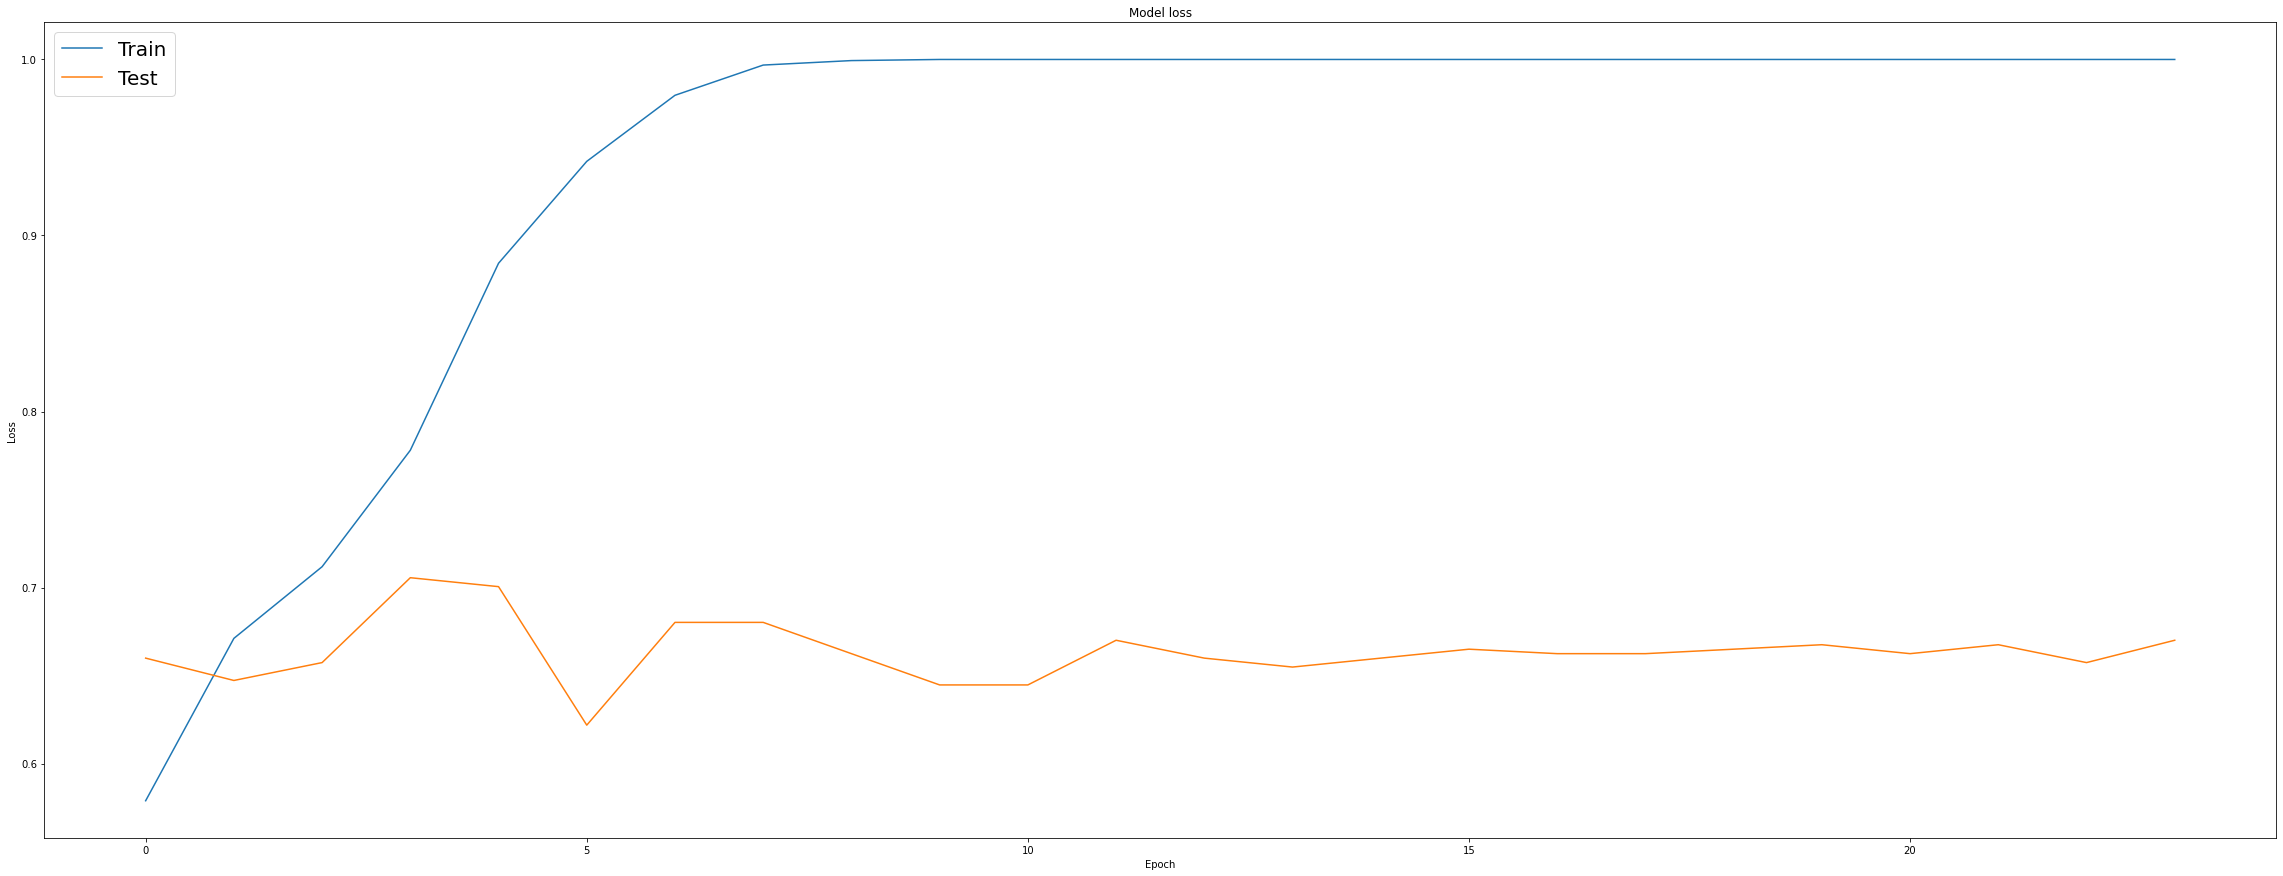

In [12]:
plt.figure(figsize = (40,15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.rcParams['font.size'] = '20'
plt.legend(['Train', 'Test'], loc='upper left', fontsize = 20)
plt.show()